<a href="https://colab.research.google.com/github/Daniyal6124/DS_Tasks_2/blob/Task1/PEA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import shap
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('/content/WA_Fn-UseC_-HR-Employee-Attrition.csv')
print(df.shape)
df.head()

(1470, 35)


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


EDA

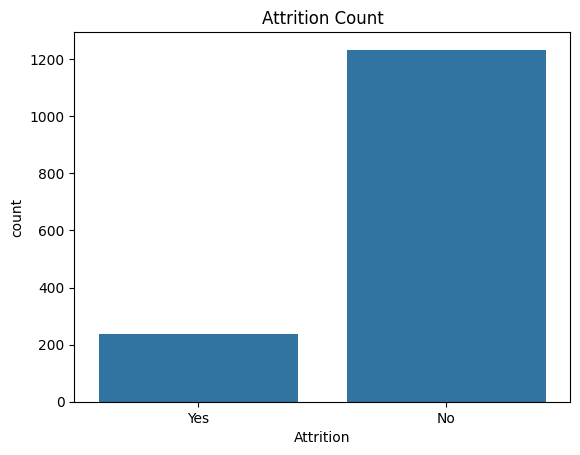

               Age    DailyRate  DistanceFromHome    Education  EmployeeCount  \
count  1470.000000  1470.000000       1470.000000  1470.000000         1470.0   
mean     36.923810   802.485714          9.192517     2.912925            1.0   
std       9.135373   403.509100          8.106864     1.024165            0.0   
min      18.000000   102.000000          1.000000     1.000000            1.0   
25%      30.000000   465.000000          2.000000     2.000000            1.0   
50%      36.000000   802.000000          7.000000     3.000000            1.0   
75%      43.000000  1157.000000         14.000000     4.000000            1.0   
max      60.000000  1499.000000         29.000000     5.000000            1.0   

       EmployeeNumber  EnvironmentSatisfaction   HourlyRate  JobInvolvement  \
count     1470.000000              1470.000000  1470.000000     1470.000000   
mean      1024.865306                 2.721769    65.891156        2.729932   
std        602.024335            

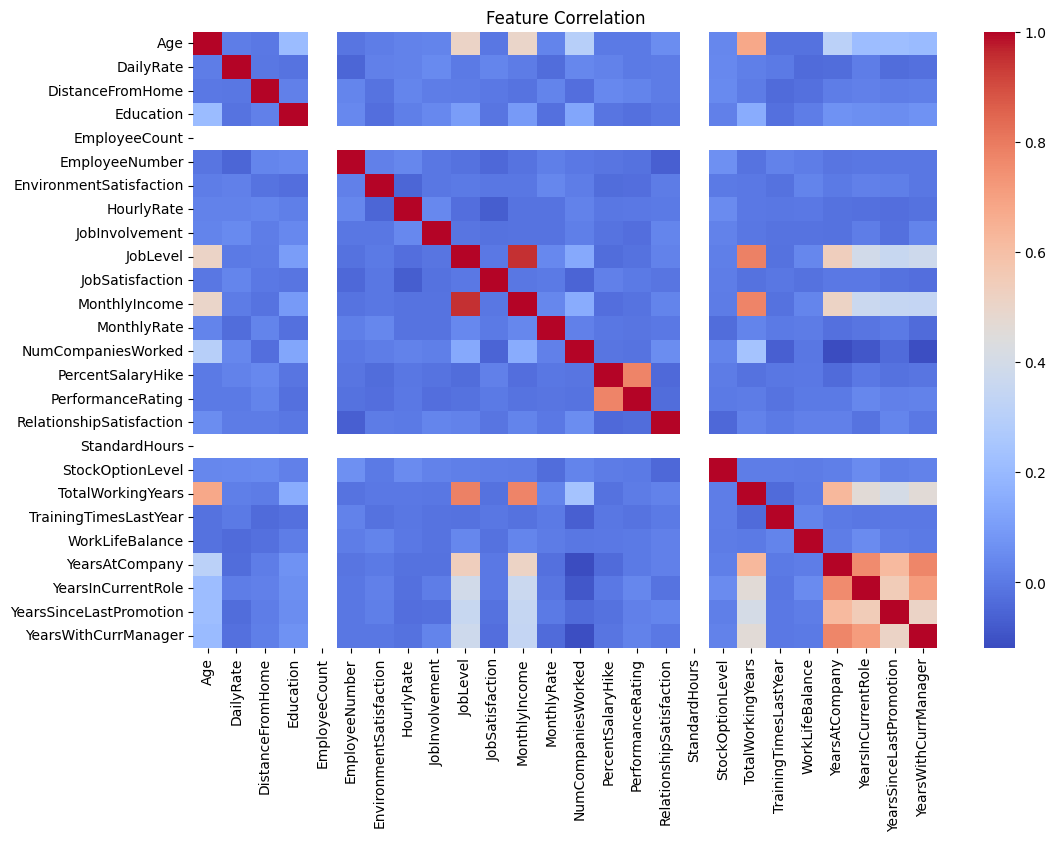

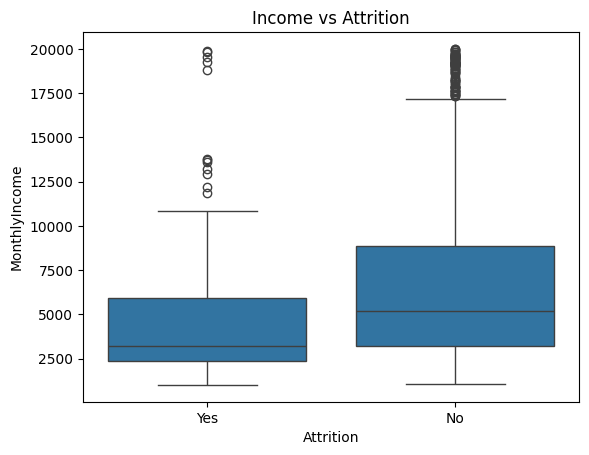

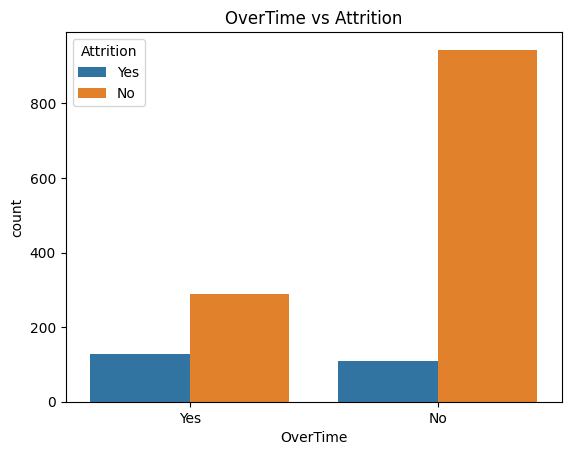

In [4]:
# Check for class balance
sns.countplot(x='Attrition', data=df)
plt.title("Attrition Count")
plt.show()

# Numerical summary
print(df.describe())

# Correlation heatmap
numerical_df = df.select_dtypes(include=np.number)
plt.figure(figsize=(12, 8))
sns.heatmap(numerical_df.corr(), cmap="coolwarm", annot=False)
plt.title("Feature Correlation")
plt.show()

# Boxplot: MonthlyIncome vs Attrition
sns.boxplot(x='Attrition', y='MonthlyIncome', data=df)
plt.title("Income vs Attrition")
plt.show()

# Countplot: Overtime vs Attrition
sns.countplot(x='OverTime', hue='Attrition', data=df)
plt.title("OverTime vs Attrition")
plt.show()


Data Processing

In [5]:
# Drop columns not useful
df.drop(['EmployeeCount', 'Over18', 'StandardHours', 'EmployeeNumber'], axis=1, inplace=True)

# Encode target variable
df['Attrition'] = df['Attrition'].apply(lambda x: 1 if x == 'Yes' else 0)

# Encode categorical features
cat_cols = df.select_dtypes(include='object').columns
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Split features and target
X = df.drop('Attrition', axis=1)
y = df['Attrition']

# Scale numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)


Training Model

In [6]:
# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Evaluation
print("Random Forest Results:")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))

print("\nLogistic Regression Results:")
print(classification_report(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, lr.predict_proba(X_test)[:,1]))


Random Forest Results:
              precision    recall  f1-score   support

           0       0.85      0.97      0.91       247
           1       0.42      0.11      0.17        47

    accuracy                           0.83       294
   macro avg       0.63      0.54      0.54       294
weighted avg       0.78      0.83      0.79       294

ROC-AUC: 0.7845637005771384

Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92       247
           1       0.62      0.34      0.44        47

    accuracy                           0.86       294
   macro avg       0.75      0.65      0.68       294
weighted avg       0.84      0.86      0.84       294

ROC-AUC: 0.8079076578516668


Model Explainability with SHAP

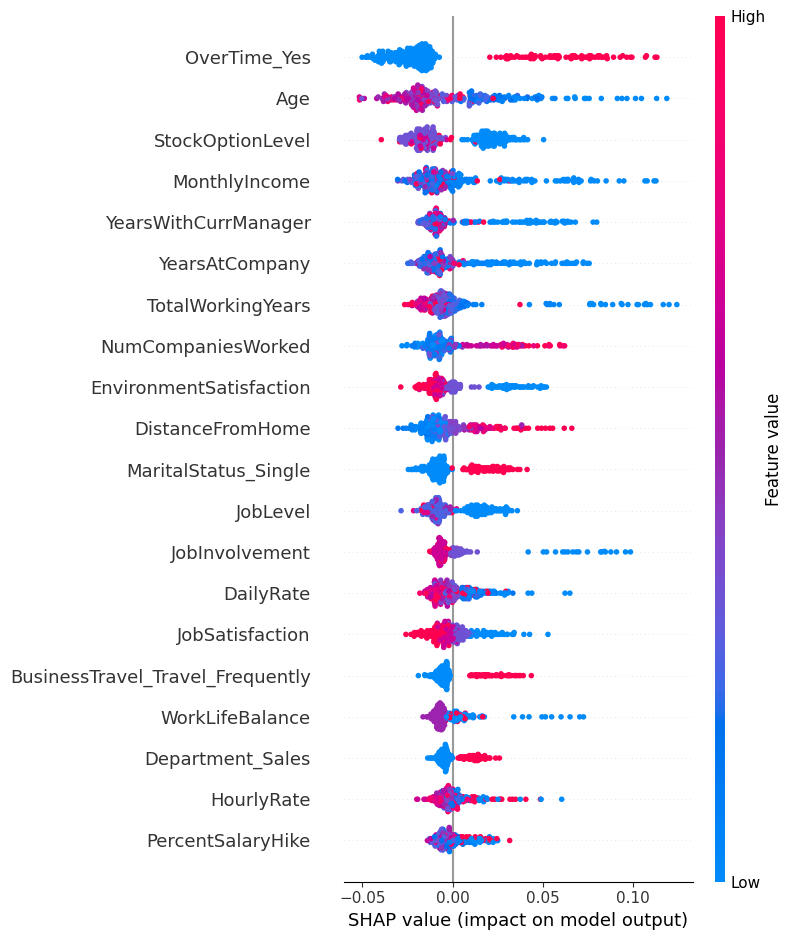

In [22]:
# SHAP explainability
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

# Summary plot (global feature importance)
# Use shap_values[:, :, 1] to get shap values for the positive class (Attrition=1) for all instances
shap.summary_plot(shap_values[:, :, 1], X_test, feature_names=X.columns)

# Force plot for one prediction
shap.initjs()
# Use shap_values[1][0] to get shap values for the first instance in X_test for the positive class
shap.force_plot(explainer.expected_value[1], shap_values[0][:,1], X_test[0], feature_names=X.columns)


Actionable Insights

In [23]:
importances = rf.feature_importances_
feature_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)
print("Top 10 Important Features:")
print(feature_imp.head(10))

Top 10 Important Features:
MonthlyIncome           0.072306
Age                     0.072260
TotalWorkingYears       0.053589
DailyRate               0.051670
HourlyRate              0.047866
DistanceFromHome        0.047793
MonthlyRate             0.047228
YearsAtCompany          0.044137
OverTime_Yes            0.037830
YearsWithCurrManager    0.035452
dtype: float64
